# 24FS\_I4DS27: Adversarial Attacks - Wie kann KI überlistet werden? <br> 08-pipeline

In diesem Notebook wird die Pipeline entwickelt und getestet.

In [1]:
%load_ext autoreload
%autoreload 2

import os
if os.getcwd() == '/home/jovyan/work': # jhub
    os.chdir("24FS_I4DS27/main/") 
    os.system("make reqs")
else: # local
    os.chdir("../")

import torch
import torchvision
import seaborn as sns
import matplotlib.pyplot as plt

pip3 install -q -r requirements.txt


In [2]:
from src.utils.uap_helper import *
from src.utils.transform_perturbation import AddImagePerturbation

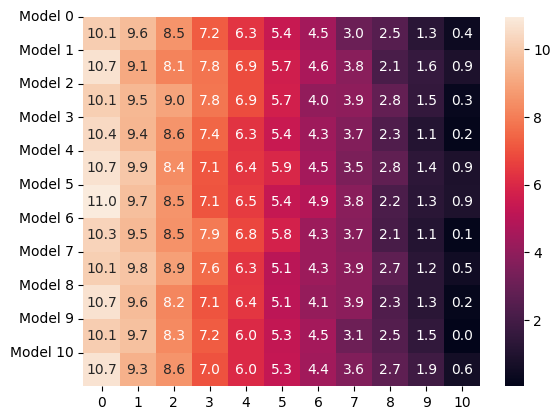

In [19]:
test_matrix = torch.linspace(10, 0, 11).repeat(11,1)
test_matrix += torch.rand_like(test_matrix)

# plot heatmap  with numbers
sns.heatmap(test_matrix, annot=True, fmt=".1f")
plt.yticks(torch.linspace(0, 10, 11), [f"Model {i}" for i in range(11)], rotation=0)
plt.xlab
plt.show()